# *ipython-sql* を使うサンプル

環境変数から接続情報を取得します。

In [1]:
import os

pgconfig = {
    'host': os.environ['PGHOST'],
    'port': os.environ['PGPORT'],
    'database': os.environ['PGDATABASE'],
    'user': os.environ['PGUSER'],
    'password': os.environ['PGPASSWORD'],
}

拡張を読み込み、データベースに接続します。

In [2]:
%load_ext sql
dsl = 'postgres://{user}:{password}@{host}:{port}/{database}'.format(**pgconfig)
%sql $dsl

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


'Connected: notebook@dsnb'

## SQL を実行してその結果を確認

SQL を実行します。

In [3]:
%%sql
select * from actor order by actor_id limit 10

10 rows affected.


actor_id,first_name,last_name,last_update
1,PENELOPE,GUINESS,2014-02-15 09:34:33
2,NICK,WAHLBERG,2014-02-15 09:34:33
3,ED,CHASE,2014-02-15 09:34:33
4,JENNIFER,DAVIS,2014-02-15 09:34:33
5,JOHNNY,LOLLOBRIGIDA,2014-02-15 09:34:33
6,BETTE,NICHOLSON,2014-02-15 09:34:33
7,GRACE,MOSTEL,2014-02-15 09:34:33
8,MATTHEW,JOHANSSON,2014-02-15 09:34:33
9,JOE,SWANK,2014-02-15 09:34:33
10,CHRISTIAN,GABLE,2014-02-15 09:34:33


実行結果を *pandas* のデータフレームに変換します。

*SqlMagic.autopandas* パラメータを `True` に設定しておくと、結果セットを pandas の DataFrame として処理してくれます。

In [4]:
%config SqlMagic.autopandas = True
df = %sql select * from actor order by actor_id
df.describe()

200 rows affected.


,actor_id
count,200.000000
mean,100.500000
std,57.879185
min,1.000000
25%,50.750000
50%,100.500000
75%,150.250000
max,200.000000


少し複雑な SQL を実行するため、店舗ごとの所在地、従業員数、顧客数を集計します。

In [5]:
%%sql
WITH store_inv AS (
    SELECT store_id, COUNT(*) AS inventory_cnt, COUNT(DISTINCT film_id) AS film_cnt
    FROM inventory GROUP BY 1
), store_staff AS (
    SELECT store_id, COUNT(*) AS staff_cnt
    FROM staff GROUP BY 1
), store_customer AS (
    SELECT store_id, COUNT(*) AS customer_cnt, SUM(active) AS active_customer_cnt
    FROM customer GROUP BY 1
)
SELECT store.store_id, addr.address, addr.district, city.city, country.country,
       store_inv.inventory_cnt, store_inv.film_cnt,
       store_staff.staff_cnt,
       store_customer.customer_cnt, store_customer.active_customer_cnt
  FROM store
LEFT JOIN address addr USING (address_id)
LEFT JOIN city USING (city_id)
LEFT JOIN country USING (country_id)
LEFT JOIN store_inv USING (store_id)
LEFT JOIN store_staff USING (store_id)
LEFT JOIN store_customer USING (store_id)
ORDER BY 1

2 rows affected.


,store_id,address,district,city,country,inventory_cnt,film_cnt,staff_cnt,customer_cnt,active_customer_cnt
0,1,47 MySakila Drive,Alberta,Lethbridge,Canada,2270,759,1,326,318
1,2,28 MySQL Boulevard,QLD,Woodridge,Australia,2311,762,1,273,266


## 結果を集計してグラフ描画

描画用にモジュールを読み込みます。

In [6]:
import seaborn as sns
%matplotlib inline

rental テーブルに商品の貸し出し情報が入っており、貸出日が *rental_date* 、返却日が *return_date* に記録されています。商品のIDは *inventory_id* で、顧客IDは *customer_id* です。これらを使い、未返却DVDのある顧客数の分布を計算して棒グラフを描画してみます。
SQL でビデオレンタルに関するデータを取得し、データフレームとして変数に保存します。

In [7]:
df = %sql select * from rental
df.head()

16044 rows affected.


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,2,2013-05-24 22:54:33,1525,459,2013-05-28 19:40:33,1,2015-02-16 02:30:53
1,3,2013-05-24 23:03:39,1711,408,2013-06-01 22:12:39,1,2015-02-16 02:30:53
2,4,2013-05-24 23:04:41,2452,333,2013-06-03 01:43:41,2,2015-02-16 02:30:53
3,5,2013-05-24 23:05:21,2079,222,2013-06-02 04:33:21,1,2015-02-16 02:30:53
4,6,2013-05-24 23:08:07,2792,549,2013-05-27 01:32:07,1,2015-02-16 02:30:53


属性ごとの項目数を確認します。

In [8]:
dt = []
for k in df.keys():
    print('{:20s} : {:,} ({:,})'.format(k, df[k].count(), df[k].nunique()))

rental_id            : 16,044 (16,044)
rental_date          : 16,044 (15,815)
inventory_id         : 16,044 (4,580)
customer_id          : 16,044 (599)
return_date          : 15,861 (15,836)
staff_id             : 16,044 (2)
last_update          : 16,044 (3)


16,044件の貸し出し情報があり、商品数は4,580件、顧客数は599人であることが分かります。また、返却日は15,861件ありますので、差し引きすると183件が未返却であると言えます。

返却日が未登録のレコードを顧客IDで集計して顧客ごとの未返却DVDの件数を計算し、さらに件数を集計することで、未返却DVDのある顧客数の分布を計算します。

In [9]:
dd = df[df['return_date'].isnull()].groupby('customer_id').count()[['rental_id',]].reset_index()
dd.groupby('rental_id').count().reset_index().rename(
    columns={'rental_id': 'rental_cnt', 'customer_id': 'customer_cnt'})

,rental_cnt,customer_cnt
0,1,136
1,2,22
2,3,1


この分布を棒グラフで表現してみます。（これくらいなら表の数値を見れば理解できる内容ではありますが）

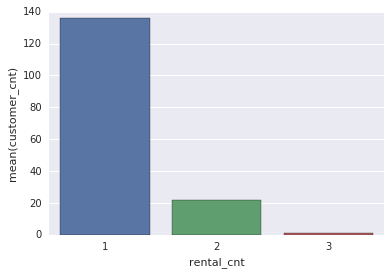

In [10]:
d = _
sns.barplot(x='rental_cnt', y='customer_cnt', data=d)

## 変数置換を利用したクエリの実行

上記のグラフを見ると、３件未返却である顧客は特殊と言えるかもしれませんので、具体的に個人を特定してみます。

In [11]:
dd[dd['rental_id'] == 3]

,customer_id,rental_id
23,75,3


顧客IDが75の人が対象であることが分かりますので、 customer テーブルで具体的に確認します。このとき、SQL に数値をハードコードするのではなく、 *ipython-sql* の変数置換を利用できます。

変数置換は、Notebook で普通の変数を定義して、SQL 文で ":" を付けることで参照できます。

In [12]:
customer_id = 75
c = %sql select * from customer where customer_id = :customer_id
c.T

1 rows affected.


,0
customer_id,75
store_id,2
first_name,TAMMY
last_name,SANDERS
email,TAMMY.SANDERS@sakilacustomer.org
address_id,79
activebool,True
create_date,2014-02-14
last_update,2014-02-15 09:57:20
active,1


変数はリストでも受け付けることができますので、特定のIDをハードコードする必要もありません。SQL の WHERE 句では IN を使います。

In [13]:
customers = tuple([int(i) for i in dd[dd['rental_id'] == 3]['customer_id'].tolist()])
c = %sql select * from customer where customer_id in :customers
c.T

1 rows affected.


,0
customer_id,75
store_id,2
first_name,TAMMY
last_name,SANDERS
email,TAMMY.SANDERS@sakilacustomer.org
address_id,79
activebool,True
create_date,2014-02-14
last_update,2014-02-15 09:57:20
active,1
